In [1]:
import sigkernel
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.chdir("..")
from src.kernel_trader_general import *
from src.utils import *
from src.simulators import *
from src.alpha_decay import *
import yfinance as yf

# Create Synthetic Data

$$
\begin{align*}
X_t & = X_t \\
Y_t & = X_t + Z_t
\end{align*}
$$

where $X_t$ is a geometric Brownian motion with zero drift and $Z_t$ is an OU process with zero mean.

In [2]:
# Data

sample_days = 1000
test_days = 1000

batch_length = 10
dim = 2
torch.manual_seed(10)

multi_sample_data = generate_gbm(n_samples=1, n_days=sample_days, mu=0.00, vol=0.01, dt=1.0, dim = 1).type(torch.float64)[0]
multi_oos_data = generate_gbm(n_samples=1, n_days=test_days, mu=0.00, vol=0.01, dt=1.0, dim = 1).type(torch.float64)[0]

sample_ou_paths = generate_OU_paths(n_samples:=1, n_days=sample_days+1, dt=1, dim=1, S_0=0,theta=0.05,sigma=0.02, mu=0)[0]
oos_ou_paths = generate_OU_paths(n_samples:=1, n_days=test_days+1, dt=1, dim=1, S_0=0,theta=0.05,sigma=0.02, mu=0)[0]

multi_sample_data = torch.cat([multi_sample_data, multi_sample_data + sample_ou_paths],dim=1).type(torch.float64)
multi_oos_data = torch.cat([multi_oos_data, multi_oos_data + oos_ou_paths],dim=1).type(torch.float64)

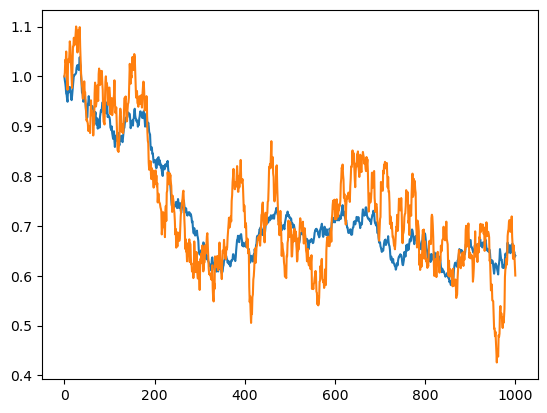

In [3]:
plt.plot(multi_sample_data)

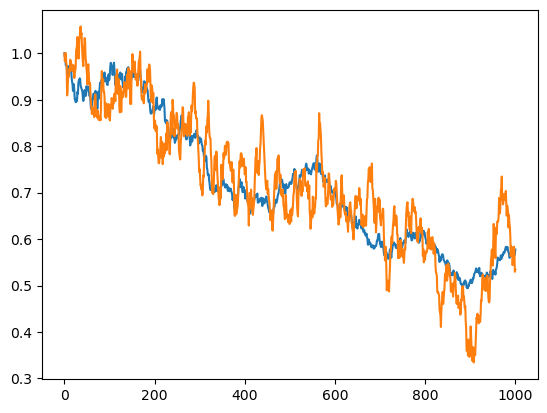

In [4]:
plt.plot(multi_oos_data)

In [10]:
dim = 2
skt = SigKernelTrader(dim=dim)
skt.compute_K(sample_path=multi_sample_data, verbose=True, dyadic_order=1)

Gram Matrix Obtained: 4.119326829910278


Alpha Obtained: 0.07420635223388672
Test PnL Obtained: 4.224187612533569
Test Return (Annualised): -0.06
Test Vol: 0.36
Test Sharpe: -0.17


/home/futter/Desktop/kernel_trading-2/src/kernel_trader.py:490: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1[i].set_yticklabels(['{:.0%}'.format(x) for x in vals])


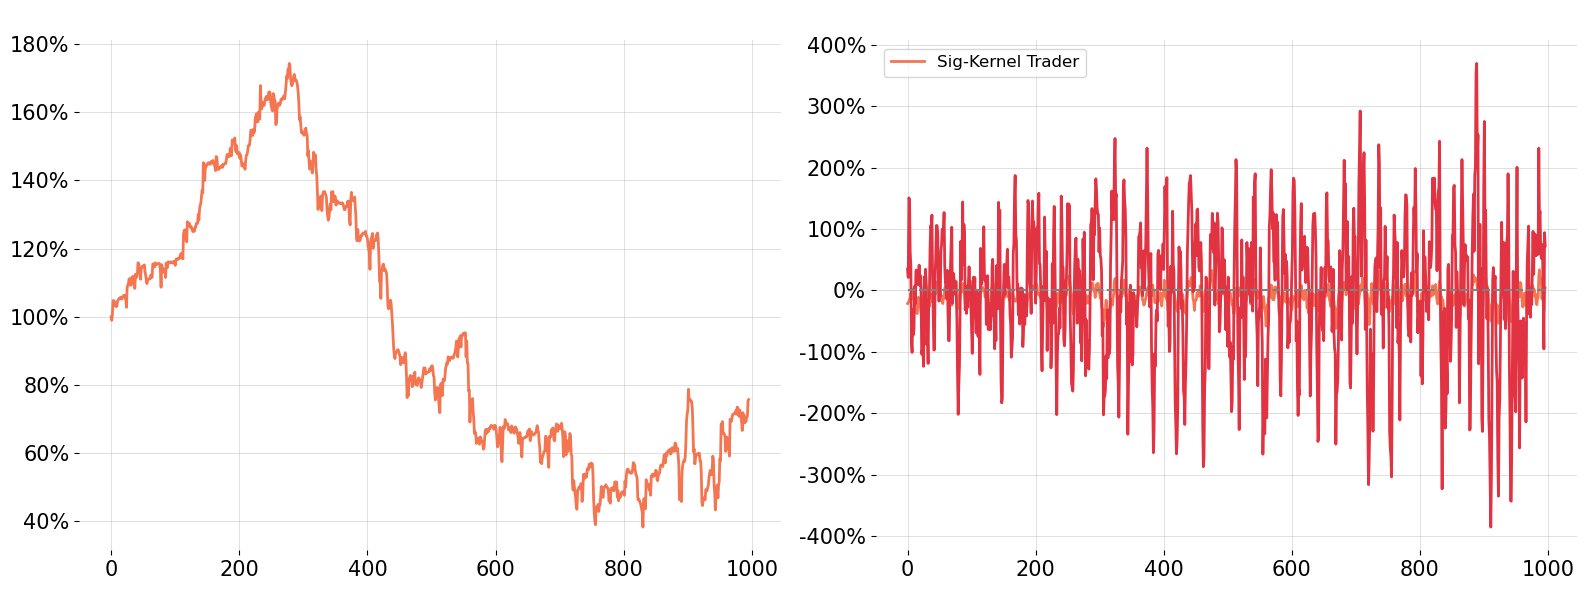

In [11]:
risk_aversion, regularisation = 5e12, 0.1
skt.fit(sample_path=multi_sample_data, verbose=True, regularisation=regularisation, risk_aversion=risk_aversion, reg_type='L2',  dyadic_order=2, K_precomputed=True, NVars=False)
skt.compute_pnl(path=multi_oos_data, sample=False, verbose=True)

skt.get_portfolio_stats()
skt.plot_strategies(sample_test='test', title=' ', position=True)

In [12]:
print('Average magnitude of Omega: ' +  "{:.6g}".format(abs(risk_aversion*skt.Omega).mean().item()))
print('Average magnitude of Alpha: ' +  "{:.6g}".format(abs(skt.alpha).mean().item()))
print('Max Alpha: ' +  "{:.6g}".format(abs(skt.alpha).max().item()))

Average magnitude of Omega: 39653.8
Average magnitude of Alpha: 1.06602e-07
Max Alpha: 1.32486e-06


<Axes: ylabel='Density'>

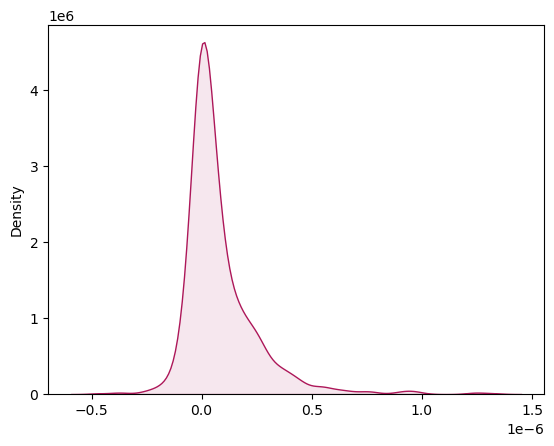

In [13]:
sns.kdeplot(skt.alpha, alpha = 0.1, color=sns.color_palette("rocket")[2], label = "Out of Sample PnL",fill=True, bw_adjust=1)

# Multiple Batches

In [14]:
N_batches = 50
batch_length = 50
sharpes = list()

for batch in range(N_batches):
    gbm_path = generate_gbm(n_samples=1, n_days=batch_length, mu=0.00, vol=0.01, dt=1.0, dim = 1).type(torch.float64)[0]
    ou_path = generate_OU_paths(n_samples:=1, n_days=batch_length+1, dt=1, dim=1, S_0=0,theta=0.55,sigma=0.02, mu=0)[0]
    multi_path = torch.cat([gbm_path, gbm_path + ou_path],dim=1).type(torch.float64)
    skt.compute_pnl(path = multi_path, sample=False, verbose=False)
    skt.compute_portfolio_stats()

    current_sharpe = skt.test_sharpe.item()
    sharpes.append(current_sharpe)

sharpes = np.array(sharpes)

<Axes: ylabel='Density'>

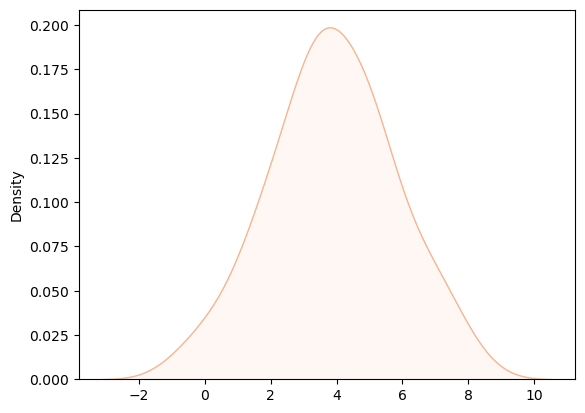

In [15]:
sns.kdeplot(sharpes, alpha = 0.1, color=sns.color_palette("rocket")[5], label = "Out of Sample PnL",fill=True, bw_adjust=1)

# Testing Regularisation when sample size is small

In [38]:
N_batches = 100
batch_length = 50
sharpes = list()
regularisations = [0, 10**(-2), 10**(-4), 10**(-6), 10**(-8), 10**(-10)]
reg_type = ['RKHS', 'L2']
reg_sharpes = torch.zeros(size=(N_batches, len(regularisations), len(reg_type)))
mean_rev = 0.1

skt = SigKernelTrader(dim=dim)
skt.compute_K(sample_path=multi_sample_data, verbose=True, dyadic_order=2)

for norm in range(len(reg_type)):

        for reg in range(len(regularisations)):

            sharpes = list()
            skt.fit(sample_path=multi_sample_data, verbose=True, risk_aversion=risk_aversion, regularisation = regularisations[reg], reg_type = reg_type[norm], K_precomputed=True)

            for batch in range(N_batches):

                gbm_path = generate_gbm(n_samples=1, n_days=batch_length, mu=0.00, vol=0.01, dt=1.0, dim = 1).type(torch.float64)[0]
                ou_path = generate_OU_paths(n_samples:=1, n_days=batch_length+1, dt=1, dim=1, S_0=0,theta=mean_rev,sigma=0.02, mu=0)[0]
                multi_path = torch.cat([gbm_path, gbm_path + ou_path],dim=1).type(torch.float64)
                skt.compute_pnl(path = multi_path, sample=False, verbose=False);
                skt.compute_portfolio_stats()

                reg_sharpes[batch, reg, norm] = skt.test_sharpe.item()


Gram Matrix Obtained: 9.863492727279663
Alpha Obtained: 0.07679080963134766
Alpha Obtained: 0.27876996994018555
Alpha Obtained: 0.40662312507629395
Alpha Obtained: 0.25412750244140625
Alpha Obtained: 0.27823734283447266
Alpha Obtained: 0.26709604263305664
Alpha Obtained: 0.27405405044555664
Alpha Obtained: 0.2691178321838379
Alpha Obtained: 0.27270054817199707
Alpha Obtained: 0.273486852645874
Alpha Obtained: 0.2714097499847412
Alpha Obtained: 0.27428579330444336


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


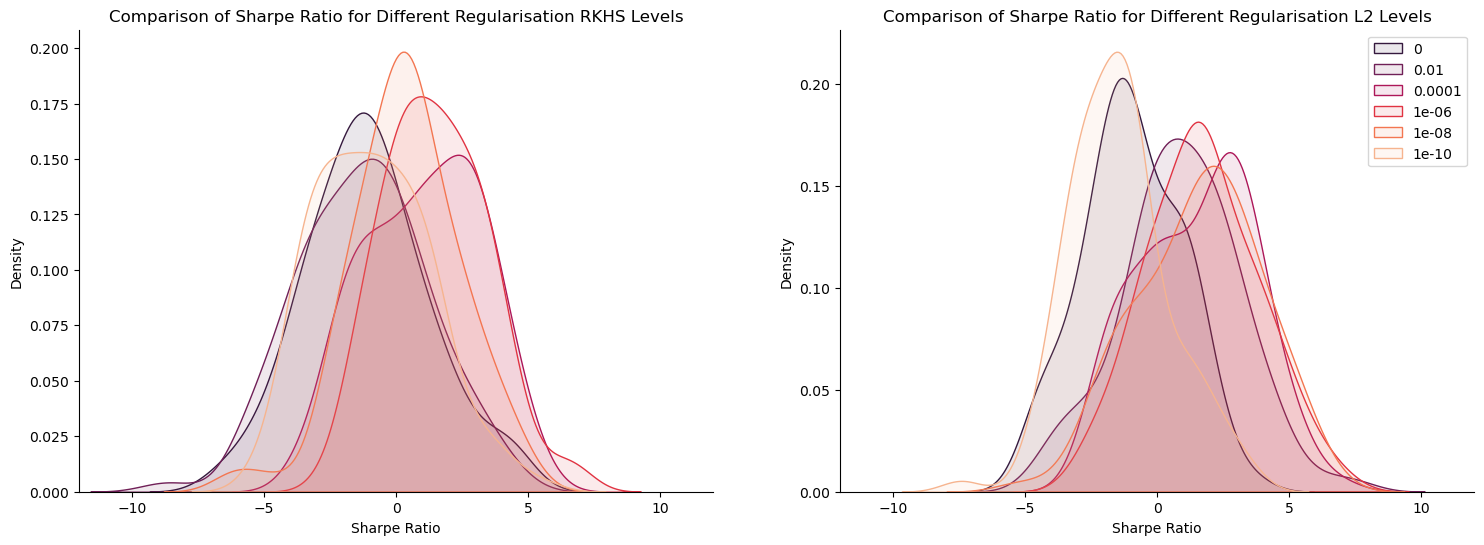

In [39]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

for j in range(2):

    for i in range(reg_sharpes.shape[1]):

        sns.kdeplot(reg_sharpes[:,i,j], alpha = 0.1, color=sns.color_palette("rocket")[i],fill=True, bw_adjust=1, label=regularisations[i], ax=ax[j])

    plt.legend(loc = "best", fontsize = 10)
    ax[j].set_title('Comparison of Sharpe Ratio for Different Regularisation ' + reg_type[j] + ' Levels', fontsize=12)
    # Set plot parameters
    ax[j].set_xlabel('Sharpe Ratio')
    ax[j].xaxis.label.set_size(10)
    right_side = ax[j].spines["right"]
    right_side.set_visible(False)
    top_side = ax[j].spines["top"]
    top_side.set_visible(False)
    ax[j].set_xlim([-12,12])
    ax[j].tick_params(axis='x', labelsize=10)
    ax[j].tick_params(axis='y', labelsize=10)
plt.show()

# Real Data


In [119]:
# "VTI AGG DBC SPY TIP GLD SPYG QQQ VTV VEA VWO TLT"
tickers = "VTI AGG DBC"
close_open = "Close"

train_start, train_end = "1990-01-01", "2019-01-01"
test_start, test_end = "2019-01-01", "2023-01-20"


df = yf.Tickers(tickers).history(period="max")[close_open].dropna() # df : [3927, 12]

sample_ts = torch.Tensor(df[(df.index >= train_start) & (df.index < train_end)].values).type(torch.float64)  # sample_ts : [2628, 12]
test_ts = torch.Tensor(df[(df.index >= test_start) & (df.index < test_end)].values).type(torch.float64) # test_ts : [1271, 12]

[*********************100%***********************]  3 of 3 completed


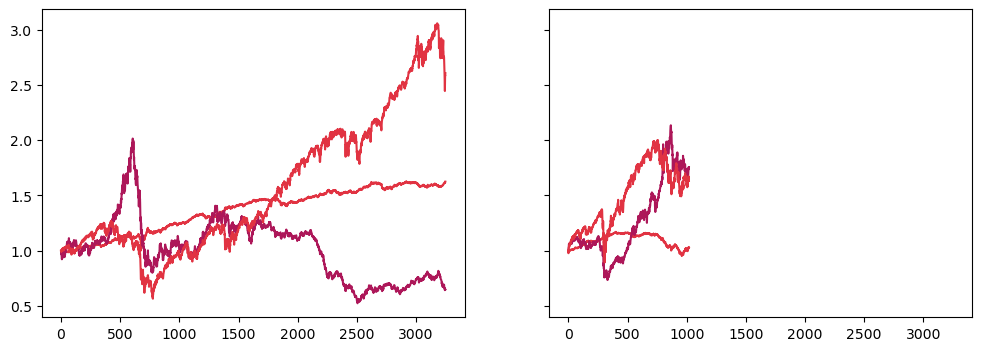

In [122]:
cmap = ListedColormap([sns.color_palette("rocket")[3], sns.color_palette("rocket")[2]])
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
ax[0].plot(sample_ts/sample_ts[0]);
ax[1].plot(test_ts/test_ts[0]);

In [123]:
risk_aversion, regularisation = 10e12, 0.00001
tx_cost = 0.0001
v2, robust_bool, NVars = True, False, False

device = 'cuda'
T = 10

skt = SigKernelTrader(dim=2)
skt.fit(sample_path=sample_ts, batch_length = T, regularisation = regularisation, verbose=True, reg_type='L2', risk_aversion=risk_aversion, dyadic_order=1, NVars=NVars)

Gram Matrix Obtained: 64.11628222465515
Alpha Obtained: 1.443274974822998


In [131]:
soft_lev, hard_lev, watermark = 4,2, 1
sample=True
skt.compute_pnl(path = test_ts, sample=sample, lookback_window = T, soft_leverage = soft_lev, hard_leverage = hard_lev, watermark=watermark, verbose=False);

In [132]:
skt.get_portfolio_stats(sample=sample)

Sample Return (Annualised): -0.01
Test Return (Annualised): -0.03
Sample Vol: 0.20
Test Vol: 0.25
Sample Sharpe: -0.04
Test Sharpe: -0.12


In [133]:
if NVars==False:
    print('Average magnitude of Omega: ' +  "{:.6g}".format(abs(risk_aversion*skt.Omega).mean().item()))
else:
    print('Average magnitude of Omega: ' +  "{:.6g}".format(abs(risk_aversion*skt.NN_Omega).mean().item()))
print('Average magnitude of Alpha: ' +  "{:.6g}".format(abs(skt.alpha).mean().item()))
print('Max Alpha: ' +  "{:.6g}".format(abs(skt.alpha).max().item()))

Average magnitude of Omega: 1572.05
Average magnitude of Alpha: 2.33743e-06
Max Alpha: 0.000118342


/home/futter/Desktop/kernel_trading-1/src/kernel_trader.py:568: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:.0%}'.format(x) for x in vals])
/home/futter/Desktop/kernel_trading-1/src/kernel_trader.py:595: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:.0%}'.format(x) for x in vals])


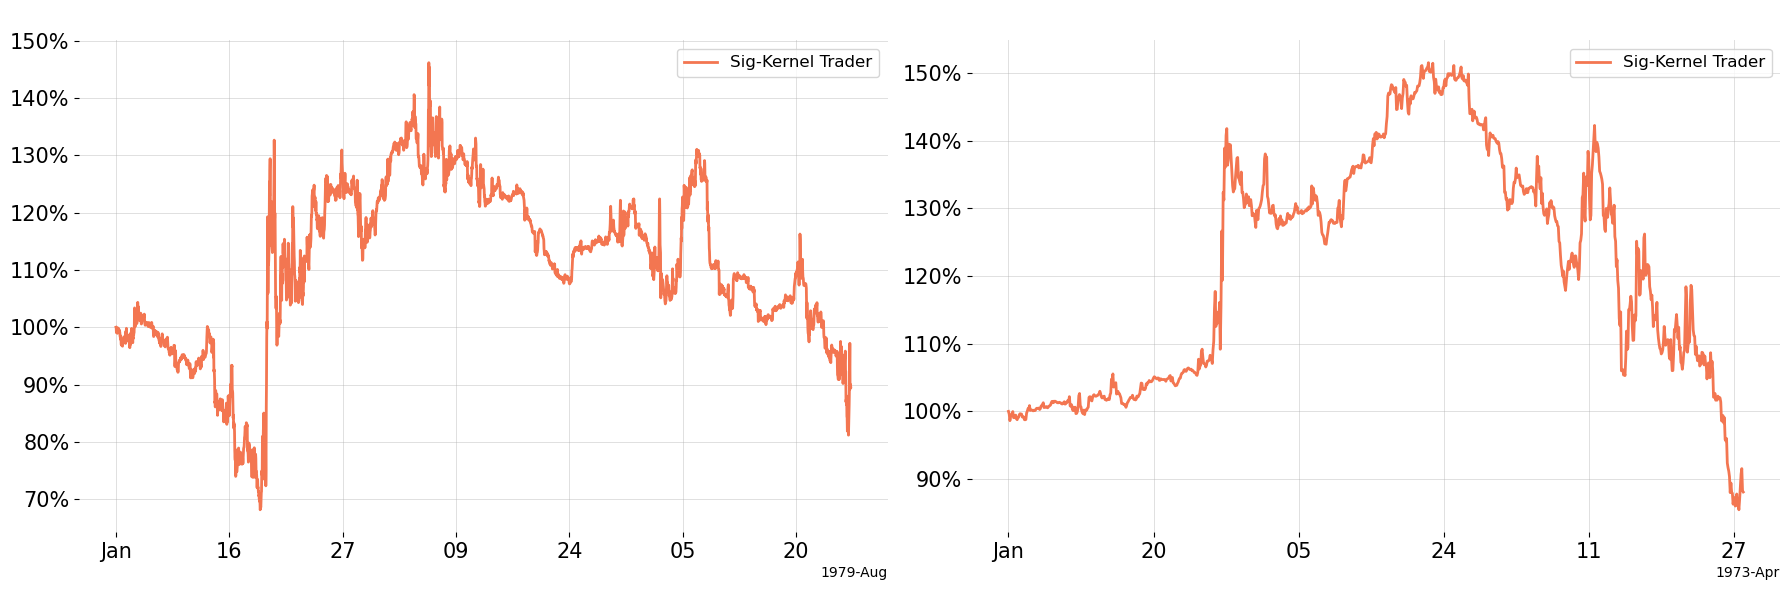

In [134]:
if sample==True:
    skt.plot_strategies(sample_test='both', title = ' ');
else:
    skt.plot_strategies(sample_test='test', title = ' ');

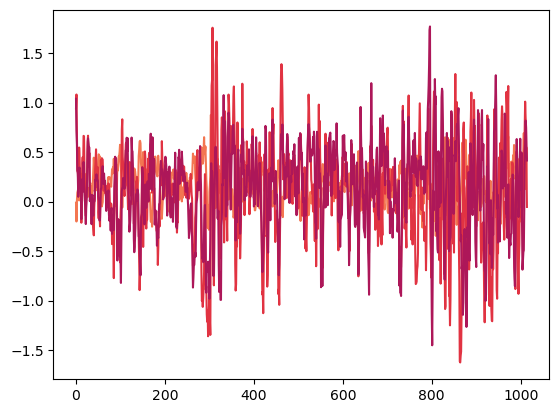

In [135]:
plt.plot(skt.position);

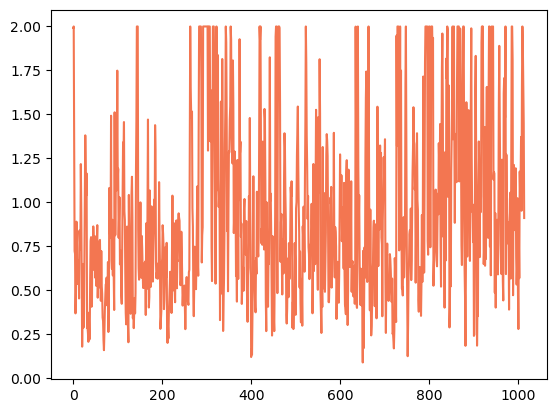

In [136]:
plt.plot(abs(skt.position).sum(dim=1));

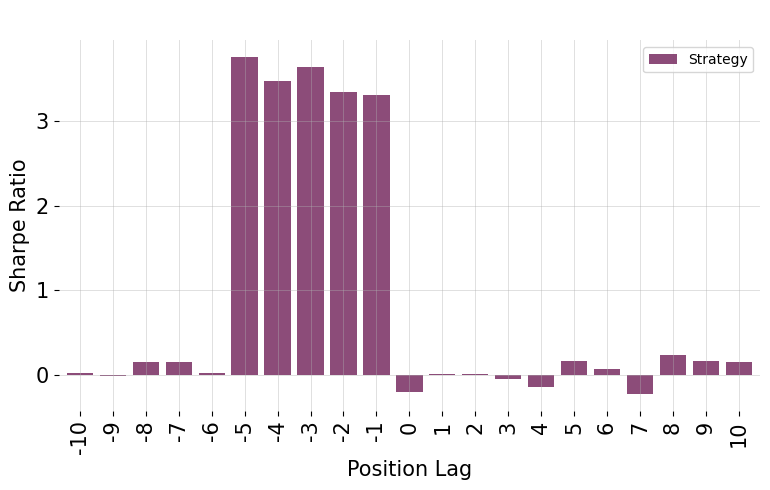

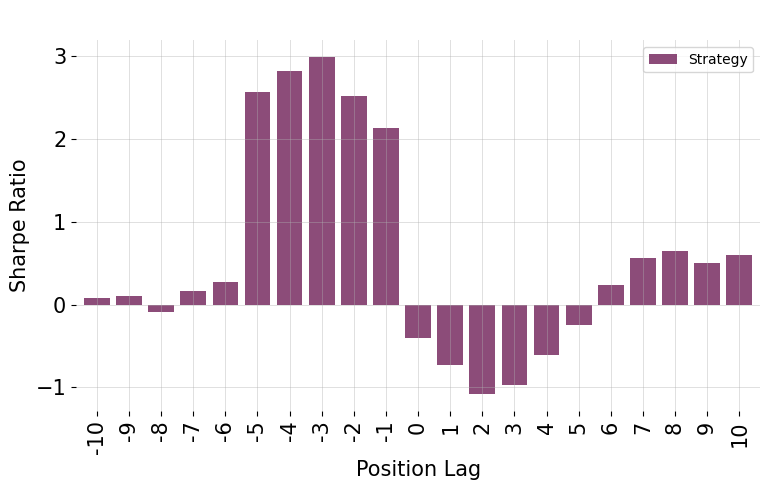

In [137]:
if sample==True:
    plot_alpha_decay(position=skt.sample_position.unsqueeze(2)[:-1], underlyings = sample_ts[-skt.sample_position.shape[0]:].unsqueeze(2), max_shift = 10)
plot_alpha_decay(position=skt.position.unsqueeze(2)[:-1], underlyings = test_ts[-skt.position.shape[0]:].unsqueeze(2), max_shift = 10)